In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv


In [2]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.tabular import *
import imageio

In [4]:
train = pd.read_csv('../input/Kannada-MNIST/train.csv')
train.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [6]:
path='../input/Kannada-MNIST'
test = pd.read_csv('../input/Kannada-MNIST/test.csv')

In [7]:
def to_img_shape(data_X, data_y=[]):
    data_X = np.array(data_X).reshape(-1,28,28)
    data_X = np.stack((data_X,)*3, axis=-1)
    data_y = np.array(data_y)
    return data_X,data_y

In [8]:
data_X, data_y = train.loc[:,'pixel0':'pixel783'], train['label']

from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(data_X, data_y, test_size=0.1,random_state=42,stratify=data_y)

test_X = test.loc[:,'pixel0':'pixel783']

In [9]:
train_X,train_y = to_img_shape(train_X, train_y)
val_X,val_y = to_img_shape(val_X,val_y)
test_X, _ = to_img_shape(test_X)

In [10]:
def save_imgs(path:Path, data, labels):
    path.mkdir(parents=True,exist_ok=True)
    for label in np.unique(labels):
        (path/str(label)).mkdir(parents=True,exist_ok=True)
    for i in range(len(data)):
        if(len(labels)!=0):
            imageio.imsave( str( path/str(labels[i])/(str(i)+'.jpg') ), data[i] )
        else:
            imageio.imsave( str( path/(str(i)+'.jpg') ), data[i] )

save_imgs(Path('/data/train'),train_X,train_y)
save_imgs(Path('/data/valid'),val_X,val_y)
save_imgs(Path('/data/test'),test_X, [])

In [11]:
#np.random.seed(42)
src = (ImageList.from_folder('/data/')
       .split_by_folder()
       .label_from_folder()
       .add_test_folder()          
       .transform(tfms, size=64)   
       .databunch())

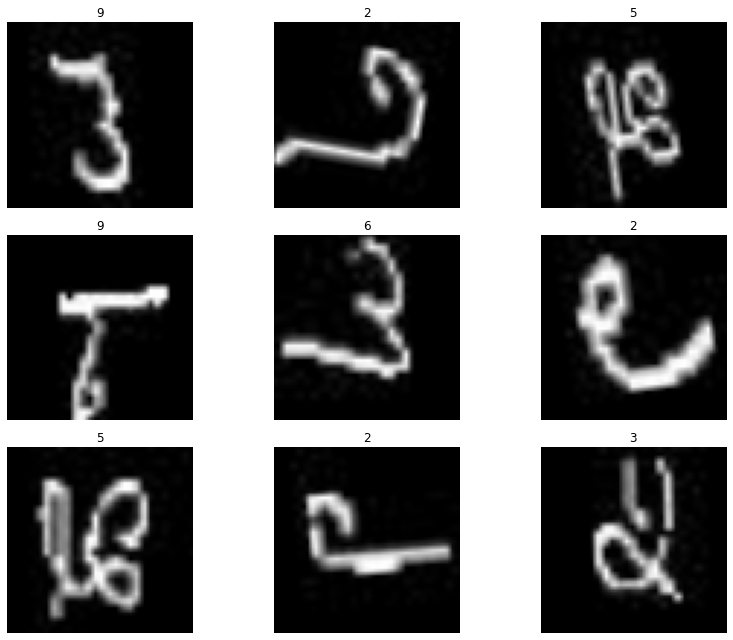

In [12]:
src.show_batch(rows=3, figsize=(12,9))

In [13]:
arch = models.resnet50

In [14]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(src, arch, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [15]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


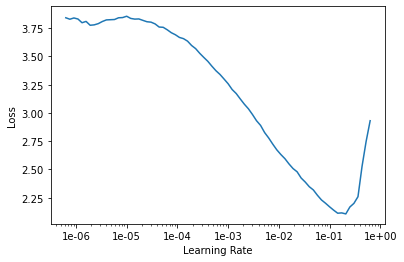

In [16]:
learn.recorder.plot()

In [17]:
lr=1e-02
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.248315,0.128864,0.957000,01:35
1,0.112466,0.055209,0.982333,01:31
2,0.060107,0.037922,0.988833,01:33


In [18]:

learn152 = cnn_learner(src, models.resnet152, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


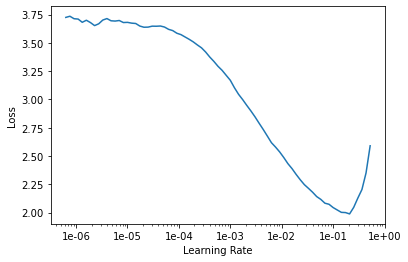

In [19]:
learn152.lr_find()
learn152.recorder.plot()

In [20]:
lr = 1e-2
learn152.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.213793,0.242465,0.952500,02:22
1,0.088866,0.089151,0.982333,02:27
2,0.052182,0.135574,0.987333,02:30
3,0.046683,0.053881,0.991667,02:26


In [21]:
learn152.unfreeze()

In [22]:
preds50, _ = learn.get_preds(DatasetType.Test)

preds152, _ = learn152.get_preds(DatasetType.Test)

In [23]:


y = torch.argmax(preds50, dim=1)

In [24]:
preds = 0.50*preds50  + 0.50*preds152

y = torch.argmax(preds, dim=1)

In [25]:
num = len(learn.data.test_ds)
indexes = {}

for i in range(num):
    filename = str(learn.data.test_ds.items[i]).split('/')[-1]
    filename = filename[:-4] # get rid of .jpg
    indexes[(int)(filename)] = i

In [26]:
submission = pd.DataFrame({ 'id': range(0, num),'label': [y[indexes[x]].item() for x in range(0, num)] })
submission.to_csv(path_or_buf ="submission.csv", index=False)